In [1]:
import os
import pprint
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch

import data
import networks as net

from networks import Generator, Discriminator
from torch.utils.data import DataLoader

torch.manual_seed(0)

plt.rcParams['image.cmap'] = 'Blues_r'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [3]:
hp_dict = {
    'run_name': 'GANs_training_1',
    'description': 'sksksksk',
    
    'image_size': (28, 28 * 5),
    
    'batch_size': 32,
    'num_epochs': 1000000,
    
    'learning_rate_discr': 0.0001,
    'learning_rate_gen': 0.0001,
    'discr_iters': 1,
    'gen_iters': 4,
    
    'alpha': 1.0,
    'beta': 5.0,
    'threshold': 0.5,
}

# extract all hyperparameters for ease of use
run_name = hp_dict['run_name']
M, N = hp_dict['image_size']

batch_size = hp_dict['batch_size']
num_epochs = hp_dict['num_epochs']

learning_rate_discr = hp_dict['learning_rate_discr']
learning_rate_gen = hp_dict['learning_rate_gen']
discr_iters = hp_dict['discr_iters']
gen_iters = hp_dict['gen_iters']

alpha = hp_dict['alpha']
beta = hp_dict['beta']
threshold = hp_dict['threshold']

In [4]:
# create output directory for this training session
try:
    os.mkdir(f'GANs_training/{run_name}')
except FileExistsError:
    shutil.rmtree(f'GANs_training/{run_name}')
    os.mkdir(f'GANs_training/{run_name}')

In [5]:
# record hyperparameters
hp_dict_str = pprint.pformat(hp_dict)

with open(f'GANs_training/{run_name}/hp_dict', 'wb+') as f:
    pkl.dump(hp_dict, f)

with open(f'GANs_training/{run_name}/hp_dict.txt', 'w+') as f:
    f.write(hp_dict_str)

In [6]:
# create dataset
dataset = data.GANs_Dataset()
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)


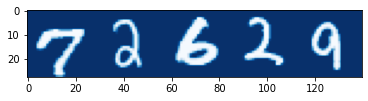

In [7]:
print(dataset.image_list[0])
plt.imshow(dataset.image_list[0][0].numpy())
plt.show()

In [8]:
def hinge_loss(gen_perturb):
    return torch.sum(torch.clip(torch.norm(gen_perturb, dim=(-1, -2)) - threshold, min=0)) / batch_size

In [9]:
# set up models
discr_model = Discriminator().double()
gen_model = Generator().double()
# target_model = # YOLO Model

# record model architectures
with open(f'GANs_training/{run_name}/discriminator_architecture_summary.txt', 'w+') as f:
    f.write(str(discr_model))
    
with open(f'GANs_training/{run_name}/generator_architecture_summary.txt', 'w+') as f:
    f.write(str(gen_model))

In [10]:
# track metrics
loss_discr_list = []
loss_gen_list = []

loss_discr_by_epoch_list = []
loss_gen_by_epoch_list = []

In [12]:
# set up or refresh optimizers
optimizer_discr = torch.optim.Adam(discr_model.parameters(), lr=learning_rate_discr, amsgrad=True)
optimizer_gen = torch.optim.Adam(gen_model.parameters(), lr=learning_rate_gen, amsgrad=True)

In [13]:
# train
discr_model.train()
gen_model.train()

for epoch in range(num_epochs):
    discr_loss_epoch, gen_loss_epoch = 0, 0
    for batch_id, (images, classes, annotations) in enumerate(dataset_loader):
        discr_loss, gen_loss = 0, 0
        for discr_i in range(discr_iters):
            gen_perturb = gen_model(images)
            images_perturb = images + gen_perturb
            
            loss_discr = net.compute_discr_loss_minimax(discr_model, images, images_perturb)
            
            optimizer_discr.zero_grad()
            loss_discr.backward()
            optimizer_discr.step()
            
            discr_loss += loss_discr.item()
            discr_loss_epoch += loss_discr.item()

        loss_discr_list.append(discr_loss / discr_iters)

        for gen_i in range(gen_iters):
            gen_perturb = gen_model(images)
            images_perturb = images + gen_perturb
            
            loss_adv = yolo_loss(images_perturb, classes, annotations)
            loss_gan = net.compute_gen_loss_minimax_modified(discr_model, images_perturb)
            loss_hinge = hinge_loss(gen_perturb)
            
            loss_gen = loss_adv + alpha * loss_gan + beta * loss_hinge
            
            gen_model.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            
            gen_loss += loss_gen.item()
            gen_loss_epoch += loss_gen.item()

        loss_gen_list.append(gen_loss / gen_iters)
            
        if batch_id % 10 == 0:
            print(f'epoch: {epoch}; batch: {batch_id}; discr loss: {discr_loss / discr_iters}; gen loss: {gen_loss / gen_iters}')
            gen_model.eval()
            discr_model.eval()
            z_vals = torch.rand(1, 1)
            print('z_val:', z_vals)
            u_funcs = gen_model(z_vals).detach()
            pl.plot_3d(u_funcs[0], 1)
            pl.plt.show()
            print('discr pred:', discr_model(u_funcs)[0].item())
            gen_model.train()
            discr_model.train()
            
    loss_discr_by_epoch_list.append(discr_loss_epoch / len(dataset_loader) / discr_iters)
    loss_gen_by_epoch_list.append(gen_loss_epoch / len(dataset_loader) / gen_iters)

RuntimeError: stack expects each tensor to be equal size, but got [5] at entry 0 and [4] at entry 1

In [ ]:
# save loss graphs
with open(f'GANs_training/{run_name}/gen_loss_list', 'wb+') as f:
    pkl.dump(loss_gen_list, f)
    
with open(f'GANs_training/{run_name}/discr_loss_list', 'wb+') as f:
    pkl.dump(loss_discr_list, f)
    
with open(f'GANs_training/{run_name}/loss_gen_by_epoch_list', 'wb+') as f:
    pkl.dump(loss_gen_by_epoch_list, f)
    
with open(f'GANs_training/{run_name}/loss_discr_by_epoch_list', 'wb+') as f:
    pkl.dump(loss_discr_by_epoch_list, f)

In [ ]:
# plot loss graphs
plt.plot(loss_discr_list, label='discr')
plt.plot(loss_gen_list, label='gen')
plt.legend()
plt.savefig(f"GANs_training/{run_name}/loss_graph.png")
plt.show()

plt.plot(loss_discr_by_epoch_list, label='discr')
plt.plot(loss_gen_by_epoch_list, label='gen')
plt.legend()
plt.savefig(f"GANs_training/{run_name}/loss_graph_by_epoch.png")
plt.show()

In [ ]:
torch.save(discr_model.state_dict(), f'GANs_training/{run_name}/discriminator_state_dict')
torch.save(gen_model.state_dict(), f'GANs_training/{run_name}/generator_state_dict')

In [ ]:
gen_model.eval()
with torch.no_grad():
    x = dataset.image_list[0].unsqueeze(0)
    perturb = gen_model(x)
    x_perturbed = x + perturb

print('original')
plt.imshow(x[0][0])
plt.show()
print('perturbation')
plt.imshow(perturb[0][0])
plt.show()
print('perturbed image')
plt.imshow(x_perturbed[0][0])
plt.show()

### Summary of Training Procedure

*give summary here to save*

In [ ]:
# make sure to save notebook before running this cell
shutil.copyfile('training.ipynb', f'GANs_training/{run_name}/training.ipynb')